In [729]:
import sys
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import json
import numpy as np

%matplotlib notebook

path = "./Chamber_Data/wallops_2_22/"

##file_name = "d1r4_gnd_decom_gse_lap"
#file_name = "d1r4_gnd_decom_kevin_lap1"
#file_name = "D1R4_gse_lap"
#file_name = "d1r4_kevin_lap" (problem)
#file_name = "d4R4_gnd_decom_gse_lap"
##file_name = "d4r4_gnd_decom_kevin_lap"
#file_name = "D4R4_gse_lap"
#file_name = "d4r4_kevin_lap"
##file_name = "data_file_230k_1_D1R4.txt"
##file_name = "data_file_230k_1.txt"
##file_name = "data_file_230k_2_D4R4.txt"
##file_name = "data_file_230k_2.txt"

#path = "./"


dataFile = path + file_name

class IMUData():
    def __init__(self):

        self.time = []; self.temp = []
        self.ax = []; self.ay = []; self.az = []
        self.mx = []; self.my = []; self.mz = []
        self.gx = []; self.gy = []; self.gz = []
        
        self.timeRpt = []; self.tempRpt = []
        self.axRpt = []; self.ayRpt = []; self.azRpt = []
        self.mxRpt = []; self.myRpt = []; self.mzRpt = []
        self.gxRpt = []; self.gyRpt = []; self.gzRpt = []
        
class SweepData():
    def __init__(self):
        self.time = []
        self.pip0 = []; self.pip1 = [];
        
        self.timeRpt = []
        self.pip0Rpt = []; self.pip1Rpt = [];
        
class PayloadData():
    def __init__(self):
        self.rawData = ''
        self.imu = IMUData()
        self.sweeps = SweepData()
        self.macAddress = ''
        self.rssiData = []
        self.shieldID = 0
        
# Functions for merging bytes
def combine2(a, b):
    return (a << 8) | b
def combine4(a, b, c, d):
    return (a << 24) | (b << 16) | (c << 8) | d

# Functions for saving data
def convertDataToLists(dataSet):
    dataSet.imu.ax = dataSet.imu.ax.tolist()
    dataSet.imu.ay = dataSet.imu.ay.tolist()
    dataSet.imu.az = dataSet.imu.az.tolist()
    dataSet.imu.mx = dataSet.imu.mx.tolist()
    dataSet.imu.my = dataSet.imu.my.tolist()
    dataSet.imu.mz = dataSet.imu.mz.tolist()
    dataSet.imu.gx = dataSet.imu.gx.tolist()
    dataSet.imu.gy = dataSet.imu.gy.tolist()
    dataSet.imu.gz = dataSet.imu.gz.tolist()
    dataSet.imu.temp = dataSet.imu.temp.tolist()
    dataSet.imu.time = dataSet.imu.time.tolist()
    dataSet.sweeps.time = dataSet.sweeps.time.tolist()
    dataSet.sweeps.pip0 = dataSet.sweeps.pip0.tolist()
    dataSet.sweeps.pip1 = dataSet.sweeps.pip1.tolist()
    
    dataSet.imu.axRpt = dataSet.imu.axRpt.tolist()
    dataSet.imu.ayRpt = dataSet.imu.ayRpt.tolist()
    dataSet.imu.azRpt = dataSet.imu.azRpt.tolist()
    dataSet.imu.mxRpt = dataSet.imu.mxRpt.tolist()
    dataSet.imu.myRpt = dataSet.imu.myRpt.tolist()
    dataSet.imu.mzRpt = dataSet.imu.mzRpt.tolist()
    dataSet.imu.gxRpt = dataSet.imu.gxRpt.tolist()
    dataSet.imu.gyRpt = dataSet.imu.gyRpt.tolist()
    dataSet.imu.gzRpt = dataSet.imu.gzRpt.tolist()
    dataSet.imu.tempRpt = dataSet.imu.tempRpt.tolist()
    dataSet.imu.timeRpt = dataSet.imu.timeRpt.tolist()
    dataSet.sweeps.timeRpt = dataSet.sweeps.timeRpt.tolist()
    dataSet.sweeps.pip0Rpt = dataSet.sweeps.pip0Rpt.tolist()
    dataSet.sweeps.pip1Rpt = dataSet.sweeps.pip1Rpt.tolist()
    return dataSet

def makeJSONFile (fname, payloadData):
    f = open(fname, 'w')
    # Convert into lists and dictionaries for JSON storage
    payloadData = convertDataToLists(payloadData)
    JSONDict = {}
    # First the IMU data
    imu = payloadData.imu
    imuData = {"time":imu.time, "temp":imu.temp,
               "ax":imu.ax, "ay":imu.ay, "az":imu.az,
               "mx":imu.mx, "my":imu.my, "mz":imu.mz,
               "gx":imu.gx, "gy":imu.gy, "gz":imu.gz}
    JSONDict["imu"] = imuData
    # Then the sweep data
    sweeps = payloadData.sweeps
    sweepData = {"id":sweeps.payloadID, "time":sweeps.time, "pip0":sweeps.pip0, "pip1":sweeps.pip1}
    JSONDict["sweeps"] = sweepData

    json.dump(JSONDict, f)
    f.close()
    
# Functions for padding data

# padding time data as lists
def timefix(l, new, dt):   # l = time data as list, new = empty list, dt = delta t
    for t in l:
        if l.index(t) >= 2:
            # replace bad timewords
            if t - l[l.index(t) - 1] < 0 or t - l[l.index(t) - 1] > 1:
                l[l.index(t) - 1] = l[l.index(t) - 2] + dt
                t = l[l.index(t) - 1] + dt

In [730]:
########### Load the data file ###########
f = open(dataFile, 'r')
rawData = f.read()

# Create payload objects and store parsed data
mainPIPData = PayloadData()
mainPIPData.rawData = rawData
payloads = [mainPIPData]

########### Parse by data type for each payload ###########
strict_parse = False # Require a pound symbol at the end of the data
for payload in payloads:
    payloadrawData = payload.rawData
    imu = []
    sweeps = []
    imuRpt = []
    sweepsRpt = []
    interrupt = []
    # 2 PIPs with 28 2-byte samples + 4-byte timestamp + ID
    sweepSamples = 28
    numSweepBytes = sweepSamples * 2 * 2 + 4 + 1
    # 9 2-byte data points + 2-byte temp + 4-byte timestamp
    numIMUBytes = 24
    # Barium interrupt
    numInterruptBytes = 4
    
    pntr = 0
    while pntr < len(payloadrawData):
        # Check message start sentinels and not at end
        if payloadrawData[pntr] == '#' and (len(payloadrawData)-pntr) >= numIMUBytes:
            if payloadrawData[pntr+1] == 'I':
                # If not the last, check message end sentinel
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                # Or just add the last message
                else:
                    imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'S':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                        sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'J':
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                else:
                    imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'T':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                        sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'B':
                if  pntr+2+numInterruptBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numInterruptBytes] == '#':
                        interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                else:
                    interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                pntr += 1
            else:
                pntr += 1
        else:
            pntr += 1
    print("Num IMU Messages: %s" %len(imu))
    print("Num Sweep Messages: %s" %len(sweeps))
    print("Num IMU Messages (buffer): %s" %len(imuRpt))
    print("Num Sweep Messages (buffer): %s" %len(sweepsRpt))
    print("Num interrupt messages: %s" %len(interrupt))

    ########### Build data structures ###########
    # First the IMU/IMU Buffer
    imuTime = [];
    ax = []; ay = []; az = []
    mx = []; my = []; mz = []
    gx = []; gy = []; gz = []
    temp = [];
    
    imuTimeRpt = [];
    axRpt = []; ayRpt = []; azRpt = []
    mxRpt = []; myRpt = []; mzRpt = []
    gxRpt = []; gyRpt = []; gzRpt = []
    tempRpt = [];
    
    for i in imu:
        if len(i) == numIMUBytes:
            imuTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            # The byte order is reversed, but the data sets are not
            ax.append(combine2(ord(i[5]), ord(i[4])))
            ay.append(combine2(ord(i[7]), ord(i[6])))
            az.append(combine2(ord(i[9]), ord(i[8])))
            mx.append(combine2(ord(i[11]), ord(i[10])))
            my.append(combine2(ord(i[13]), ord(i[12])))
            mz.append(combine2(ord(i[15]), ord(i[14])))
            gx.append(combine2(ord(i[17]), ord(i[16])))
            gy.append(combine2(ord(i[19]), ord(i[18])))
            gz.append(combine2(ord(i[21]), ord(i[20])))
            temp.append(combine2(ord(i[23]), ord(i[22])))
    
    for i in imuRpt:
        if len(i) == numIMUBytes:
            imuTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            axRpt.append(combine2(ord(i[5]), ord(i[4])))
            ayRpt.append(combine2(ord(i[7]), ord(i[6])))
            azRpt.append(combine2(ord(i[9]), ord(i[8])))
            mxRpt.append(combine2(ord(i[11]), ord(i[10])))
            myRpt.append(combine2(ord(i[13]), ord(i[12])))
            mzRpt.append(combine2(ord(i[15]), ord(i[14])))
            gxRpt.append(combine2(ord(i[17]), ord(i[16])))
            gyRpt.append(combine2(ord(i[19]), ord(i[18])))
            gzRpt.append(combine2(ord(i[21]), ord(i[20])))
            tempRpt.append(combine2(ord(i[23]), ord(i[22])))

    imuTime = np.array(imuTime, dtype='uint32')
    ax = np.array(ax, dtype='int16')
    ay = np.array(ay, dtype='int16')
    az = np.array(az, dtype='int16')
    mx = np.array(mx, dtype='int16')
    my = np.array(my, dtype='int16')
    mz = np.array(mz, dtype='int16')
    gx = np.array(gx, dtype='int16')
    gy = np.array(gy, dtype='int16')
    gz = np.array(gz, dtype='int16')
    temp = np.array(temp, dtype='int16')
    
    imuTimeRpt = np.array(imuTimeRpt, dtype='uint32')
    axRpt = np.array(axRpt, dtype='int16')
    ayRpt = np.array(ayRpt, dtype='int16')
    azRpt = np.array(azRpt, dtype='int16')
    mxRpt = np.array(mxRpt, dtype='int16')
    myRpt = np.array(myRpt, dtype='int16')
    mzRpt = np.array(mzRpt, dtype='int16')
    gxRpt = np.array(gxRpt, dtype='int16')
    gyRpt = np.array(gyRpt, dtype='int16')
    gzRpt = np.array(gzRpt, dtype='int16')
    tempRpt = np.array(tempRpt, dtype='int16')

    payload.imu.time = imuTime
    payload.imu.ax = ax
    payload.imu.ay = ay
    payload.imu.az = az
    payload.imu.mx = mx
    payload.imu.my = my
    payload.imu.mz = mz
    payload.imu.gx = gx
    payload.imu.gy = gy
    payload.imu.gz = gz
    payload.imu.temp = temp
    
    payload.imu.timeRpt = imuTimeRpt
    payload.imu.axRpt = axRpt
    payload.imu.ayRpt = ayRpt
    payload.imu.azRpt = azRpt
    payload.imu.mxRpt = mxRpt
    payload.imu.myRpt = myRpt
    payload.imu.mzRpt = mzRpt
    payload.imu.gxRpt = gxRpt
    payload.imu.gyRpt = gyRpt
    payload.imu.gzRpt = gzRpt
    payload.imu.tempRpt = tempRpt

    # Then the sweeps
    payloadID = [];
    sweepTime = []
    allSweepsPIP0 = []
    individualSweepsPIP0 = []
    allSweepsPIP1 = []
    individualSweepsPIP1 = []
    PIP0StartByte = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByte = PIP0StartByte + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByte = PIP0StopByte + sweepSamples*2      # Number of samples, two bytes each
    
    sweepTimeRpt = []
    allSweepsPIP0Rpt = []
    individualSweepsPIP0Rpt = []
    allSweepsPIP1Rpt = []
    individualSweepsPIP1Rpt = []
    PIP0StartByteRpt = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByteRpt = PIP0StartByteRpt + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByteRpt = PIP0StopByteRpt + sweepSamples*2      # Number of samples, two bytes each
    
    for i in sweeps:
        if len(i) == numSweepBytes:
            sweepTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            payloadID.append(ord(i[4]))
            tempSweep = []
            for byte in xrange(PIP0StartByte,PIP0StopByte,2):
                allSweepsPIP0.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP0.append(tempSweep)
            tempSweep = []
            for byte in xrange(PIP0StopByte,PIP1StopByte,2):
                allSweepsPIP1.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP1.append(tempSweep)
            
    for i in sweepsRpt:
        if len(i) == numSweepBytes:
            sweepTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            tempSweepRpt = []
            for byte in xrange(PIP0StartByteRpt,PIP0StopByteRpt,2):
                allSweepsPIP0Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP0Rpt.append(tempSweepRpt)
            tempSweepRpt = []
            for byte in xrange(PIP0StopByteRpt,PIP1StopByteRpt,2):
                allSweepsPIP1Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP1Rpt.append(tempSweepRpt)
            
    interruptTime = []        
    for i in interrupt:
        if len(i) == numInterruptBytes:
            interruptTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
                       
    payloadMatch = (len(set(payloadID)) == 1)
    if payloadMatch:
        print("Payload ID's match. This was payload #%s." %payloadID[0])
    else:
        print("Payload ID's don't match. Something went wrong...")
        
    sweepTime = np.array(sweepTime, dtype='uint32')
    individualSweepsPIP0 = np.array(individualSweepsPIP0, dtype='int16')
    individualSweepsPIP1 = np.array(individualSweepsPIP1, dtype='int16')
    payload.shieldID = payloadID[0]
    payload.sweeps.time = sweepTime
    payload.sweeps.pip0 = individualSweepsPIP0
    payload.sweeps.pip1 = individualSweepsPIP1
    
    sweepTimeRpt = np.array(sweepTimeRpt, dtype='uint32')
    individualSweepsPIP0Rpt = np.array(individualSweepsPIP0Rpt, dtype='int16')
    individualSweepsPIP1Rpt = np.array(individualSweepsPIP1Rpt, dtype='int16')
    payload.sweeps.timeRpt = sweepTimeRpt
    payload.sweeps.pip0Rpt = individualSweepsPIP0Rpt
    payload.sweeps.pip1Rpt = individualSweepsPIP1Rpt

Num IMU Messages: 1878
Num Sweep Messages: 1878
Num IMU Messages (buffer): 1878
Num Sweep Messages (buffer): 1878
Num interrupt messages: 0
Payload ID's match. This was payload #16.


In [731]:
################################## Forming and Scaling Data ##################################### 

sweepSize = 28
sweepStepDt = 0.02 / sweepSize

# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None

# Set by the time limits automatically
timesToSkip = 30 # To impove the quality of sample numbering selection
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None

for payload in payloads:
    # Extract data from each set, cast into arrays
    aScale = 4*9.8; mScale = 1.; gScale = 2000./360
    
    imuTime = np.array(payload.imu.time)/1.E6;
    sweepTime = np.array(payload.sweeps.time)/1.E6
    
    imuTimeRpt = np.array(payload.imu.timeRpt)/1.E6;
    sweepTimeRpt = np.array(payload.sweeps.timeRpt)/1.E6
    
    # Figure out what the sample bounds should be
    if timeMin:
        IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip]
        IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip]
        SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip]
        SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip]
    imuTime = imuTime[IMUSampleMin:IMUSampleMax]
    sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]
    
    ############################################################
    ##Bringing in from parse_erpabob-2 to use for lineplots
    # Flatten out sweepSampleTime 
    sweepSampleTime = []
    for t in sweepTime:
        for n in range(0, sweepSize):
            sweepSampleTime.append(t+sweepStepDt*n)
    sweepSampleTime = np.array(sweepSampleTime)
    
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    pip1L = pip1.flatten();
    pip0L = pip0.flatten();
    
    sweepSampleTimeRpt = []
    for t in sweepTimeRpt: 
        for n in range(0, sweepSize):
            sweepSampleTimeRpt.append(t+sweepStepDt*n)
    sweepSampleTimeRpt = np.array(sweepSampleTimeRpt)
    
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    pip0RptL = pip0Rpt.flatten();
    pip1RptL = pip1Rpt.flatten();
    #SweepSampleMin = SweepSampleMin * sweepSize # Scale up sizing
    #SweepSampleMax = SweepSampleMax * sweepSize
    ############################################################
     
    # Make everything an array
    interruptArray = np.array(interruptTime)/10**6
    
    temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
    ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
    az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
    my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
    shieldID = payload.shieldID
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    
    tempRpt = payload.imu.tempRpt[IMUSampleMin:IMUSampleMax];
    axRpt = np.array(payload.imu.axRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ayRpt = np.array(payload.imu.ayRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    azRpt = np.array(payload.imu.azRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mxRpt = np.array(payload.imu.mxRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    myRpt = np.array(payload.imu.myRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mzRpt = np.array(payload.imu.mzRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gxRpt = np.array(payload.imu.gxRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gyRpt = np.array(payload.imu.gyRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gzRpt = np.array(payload.imu.gzRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    
    print("Data Scaled")
############################ Padding Data #######################################

    # Change time data to list form for padding
    imuList = imuTime.tolist()
    sweepList = sweepTime.tolist()
    
    imuListRpt = imuTimeRpt.tolist()
    sweepListRpt = sweepTimeRpt.tolist()
    
    # Find correct delta t
    imuDelt = round(((imuList[300] - imuList[100]) / 200), 4)
    sweepDelt = round(((sweepList[300] - sweepList[100]) / 200), 4)
    
    imuDeltRpt = round(((imuListRpt[300] - imuListRpt[100]) / 200), 4)
    sweepDeltRpt = round(((sweepListRpt[300] - sweepListRpt[100]) / 200), 4)
    print("Deltas found")
    newImuTime =  []
    newSweepTime = []
    
    newImuTimeRpt =  []
    newSweepTimeRpt = []
    
    # iterate through IMU twice to better fill gaps
    timefix(imuList, newImuTime, imuDelt)
    timefix(imuList, newImuTime, imuDelt)
    print("IMU Original")
    
    timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
    timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
    print("IMU Time Done")
    
    # iterate through sweep
    timefix(sweepList, newSweepTime, sweepDelt)
    timefix(sweepList, newSweepTime, sweepDelt)
    print("Sweep Original")
    
    timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
    timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
    
    print("Sweep Time Done")
    
    # change back to array
    imuList = np.array(imuList)
    sweepList = np.array(sweepList)
    
    imuListRpt = np.array(imuListRpt)
    sweepListRpt = np.array(sweepListRpt)
    
    # reshape all data
    ax = np.reshape(ax, (len(ax), 1))
    ay = np.reshape(ay, (len(ay), 1))
    az = np.reshape(az, (len(az), 1))
    gx = np.reshape(gx, (len(gx), 1))
    gy = np.reshape(gy, (len(gy), 1))
    gz = np.reshape(gz, (len(gz), 1))
    mx = np.reshape(mx, (len(mx), 1))
    my = np.reshape(my, (len(my), 1))
    mz = np.reshape(mz, (len(mz), 1))
    temp = np.reshape(temp, (len(temp), 1))
    
    axRpt = np.reshape(axRpt, (len(axRpt), 1))
    ayRpt = np.reshape(ayRpt, (len(ayRpt), 1))
    azRpt = np.reshape(azRpt, (len(azRpt), 1))
    gxRpt = np.reshape(gxRpt, (len(gxRpt), 1))
    gyRpt = np.reshape(gyRpt, (len(gyRpt), 1))
    gzRpt = np.reshape(gzRpt, (len(gzRpt), 1))
    mxRpt = np.reshape(mxRpt, (len(mxRpt), 1))
    myRpt = np.reshape(myRpt, (len(myRpt), 1))
    mzRpt = np.reshape(mzRpt, (len(mzRpt), 1))
    tempRpt = np.reshape(tempRpt, (len(tempRpt), 1))
    
    
    print("Rest Done")
#     print("Length of IMUList is " + str(len(imuList)))
#     print("Length of sweepList is " + str(len(sweepList)))
#     print("Length of IMUList (buffer) is " + str(len(imuListRpt)))
#     print("Length of sweepList (buffer) is " + str(len(sweepListRpt)))
    
    interruptValue = (len(set(interruptArray[100:200])) == 1)
    if interruptValue and len(interruptArray) > 100:
         print("Time of interrupt is at " + str(interruptArray[100]) + " seconds.")
    else:
         print("Something wrong. Interrupt time doesn't make sense.")

Data Scaled
Deltas found
IMU Original
IMU Time Done
Sweep Original
Sweep Time Done
Rest Done
Something wrong. Interrupt time doesn't make sense.


In [732]:
# Changes screen voltage to nA

highV2I = 1.0/(320.0E-3)
lowV2I = 1.0/(40.0E-3)

pip0nA = (pip0-1)*highV2I
pip1nA = (pip1-1)*highV2I
pip0RptnA = (pip0Rpt-1)*highV2I
pip1RptnA = (pip1Rpt-1)*highV2I

In [733]:
# choose original or repeat
plottype = 1

if plottype == 1:
    version = 'Original'
    imuPlot = imuList
    axPlot = ax
    ayPlot = ay
    azPlot = az
    gxPlot = gx
    gyPlot = gy
    gzPlot = gz
    mxPlot = mx
    myPlot = my
    mzPlot = mz
    tempPlot = temp
    sweepPlot = sweepList
    pip0Plot = pip0nA
    pip1Plot = pip1nA 
    
    pip0LPlot = pip0L
    pip1LPlot = pip1L
    sweepTimeLPlot = sweepSampleTime
    
elif plottype == 2:
    version = 'Repeat'
    imuPlot = imuListRpt
    axPlot = axRpt
    ayPlot = ayRpt
    azPlot = azRpt
    gxPlot = gxRpt
    gyPlot = gyRpt
    gzPlot = gzRpt
    mxPlot = mxRpt
    myPlot = myRpt
    mzPlot = mzRpt
    tempPlot = tempRpt
    sweepPlot = sweepListRpt
    pip0Plot = pip0RptnA
    pip1Plot = pip1RptnA
    
    pip0LPlot = pip0RptL
    pip1LPlot = pip1RptL
    sweepTimeLPlot = sweepSampleTimeRpt

In [734]:
magfullPlot = mxPlot**2+myPlot**2+mzPlot**2

In [735]:
#Modify PIP Lineplots' and colorplots' x-axis limits and set PIP colorplots' colorbar limits
xlims = [200, 200.5]
xlims2 = [400, 400.5]
xlims = [sweepPlot[0]-5, sweepPlot[-1]+5]
xlims2 = [sweepPlot[0]-5, sweepPlot[-1]+5]
cplt_kwargs={'pip0': {'vmin':0, 'vmax':1}, 'pip1':{'vmin':0, 'vmax':1}}

<IPython.core.display.Javascript object>


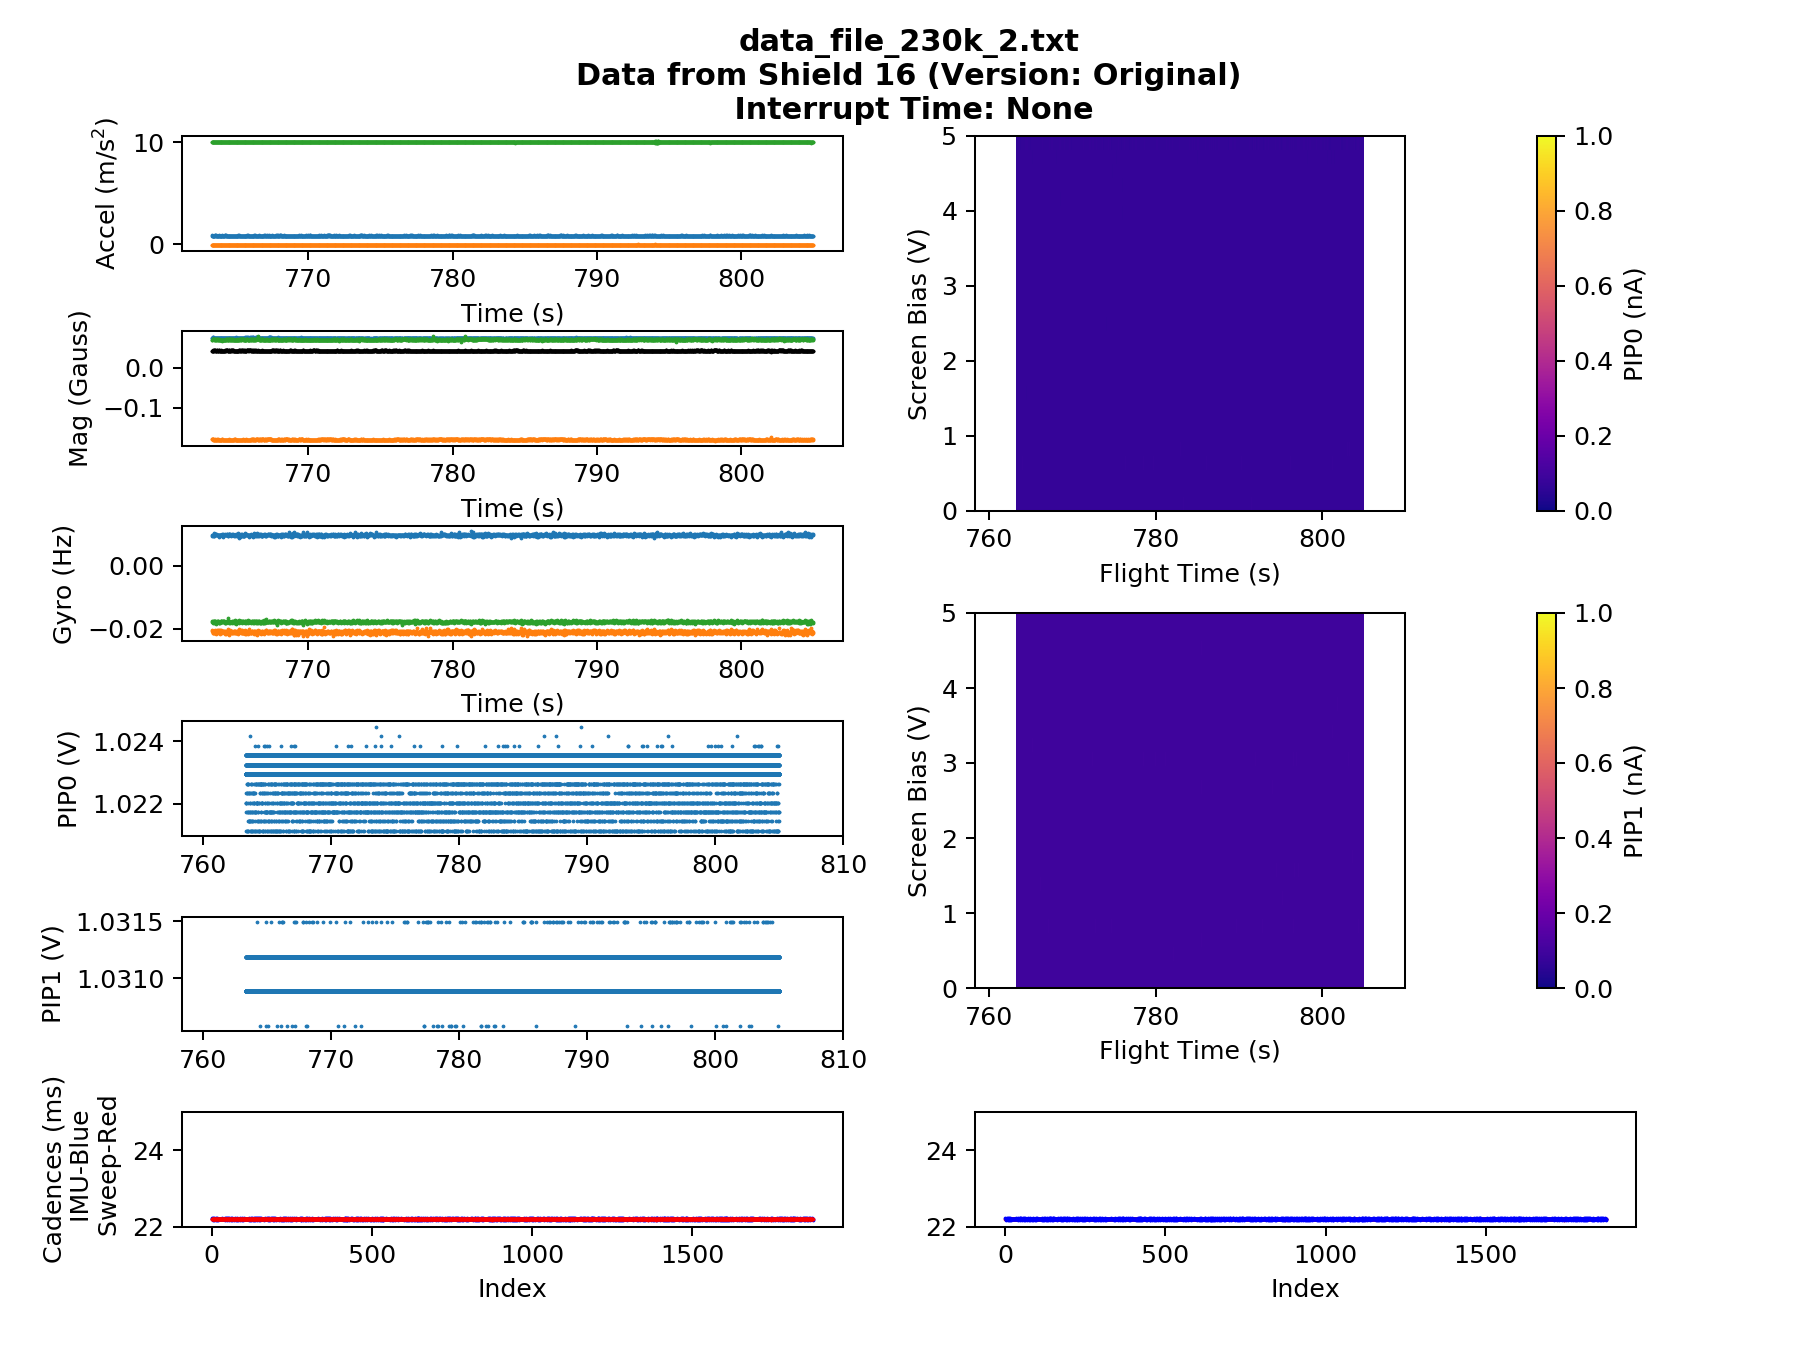

1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done


In [736]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
from __future__ import division

dots = True

gs_left = plt.GridSpec(6, 2,  hspace=0.7)

# Set up dots or not more cleanly
line_style = '-'
if dots:
    line_style = '.'

markersize = 1

fig = plt.figure(figsize=(10, 7.5))

# Accel
axis = fig.add_subplot(gs_left[0,0])
plt.plot(imuPlot, axPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, ayPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, azPlot, line_style, markersize=markersize) 
plt.ylabel("Accel (m/s$^2$)")
#plt.ylim([-2, 2])
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("1 Done")

# Mag
fig.add_subplot(gs_left[1,0])
plt.plot(imuPlot, mxPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, myPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, mzPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, magfullPlot, line_style, markersize=markersize, color='black')
#plt.ylim([-0.2, 0.25])
plt.ylabel("Mag (Gauss)") 
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("2 Done")

# Gyro
fig.add_subplot(gs_left[2,0])
plt.plot(imuPlot, gxPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, gyPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, gzPlot, line_style, markersize=markersize) 
plt.ylabel("Gyro (Hz)")
#plt.ylim([-0.5, 0.5])  
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("3 Done")

# First PIP (line)
fig.add_subplot(gs_left[3,0])
plt.plot(sweepTimeLPlot, pip0LPlot, line_style, markersize=markersize)
plt.ylabel("PIP0 (V)")
#plt.ylim([1.01, 1.03])
plt.xlim(xlims)
print("4 Done")

# Second PIP (line)
fig.add_subplot(gs_left[4,0])
plt.plot(sweepTimeLPlot, pip1LPlot, line_style, markersize=markersize)
#plt.ylim([1.027, 1.033])
plt.xlim(xlims2)
plt.ylabel("PIP1 (V)")
print("5 Done")

# Cadence (sweep on top)
axis2 = fig.add_subplot(gs_left[5,0])
plt.plot(np.diff(imuPlot*1E3), line_style, color='blue', markersize=markersize)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
plt.ylim([22,25])
#plt.xlim([200,400])
plt.ylabel("Cadences (ms)\n IMU-Blue\n Sweep-Red")
plt.xlabel("Index")
print ("6 Done")

# Cadence (imu on top)
fig.add_subplot(gs_left[5,1], sharex=axis2, sharey=axis2)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
plt.plot(np.diff(imuPlot*1E3), line_style, color='blue', markersize=markersize)
plt.ylim([22,25])
#plt.xlim([200,400])
plt.xlabel("Index")
print ("7 Done")

# **Plot sweep time vs sweep data (Color plots)**

# commands to reorient pip array to match with other axes
pip0_rot = np.rot90(pip0Plot, k=1, axes=(0, 1))
pip1_rot = np.rot90(pip1Plot, k=1, axes=(0, 1))

sweep_voltage = np.linspace(0,5,28)

line_style = '-'

ax1 = plt.subplot2grid((5,2),(0,1),rowspan = 2)
plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
plt.xlim(xlims)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP0 (nA)")
print ("8 Done")

ax1 = plt.subplot2grid((5,2),(2,1),rowspan = 2)
plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])
plt.xlim(xlims2)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP1 (nA)")
print ("9 Done")
        
# Adjust figure
fig.subplots_adjust(right=.90)
fig.subplots_adjust(left=0.10)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)

if interruptValue and len(interruptArray) > 100:
    interruptNum = str(interruptArray[100]) + " seconds"
else:
    interruptNum = "None"
    
plt.suptitle(file_name+"\n"+"Data from Shield %s (Version: %s)\n Interrupt Time: %s" 
             %(shieldID, version, interruptNum), fontweight='bold')
    
plt.show()